In [25]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [26]:
#Importing tree and ensemble models
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

In [27]:
#Reading the dataset
df=pd.read_csv('C:\\Users\\parth\\OneDrive\\Documents\\UT Austin\\DS Programming\\Project\\NASA\\dataset\\neo_v2.csv')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [28]:
No_of_true=len(df[df['hazardous']==True])
No_of_false=len(df[df['hazardous']==False])

print('Baseline Accuracy is approx',(No_of_false)/(No_of_true+No_of_false))

Baseline Accuracy is approx 0.90268175613193


In [29]:
#First we check for null values
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [30]:
#So there are no missing values
#Now we convert the target variable to 0,1
def convert_to_int(X):
    return int(X)
df['hazardous']=df['hazardous'].map(convert_to_int)
#Now we check the columns orbiting_body and sentry_object
print(df['orbiting_body'].value_counts())
print(df['sentry_object'].value_counts())

Earth    90836
Name: orbiting_body, dtype: int64
False    90836
Name: sentry_object, dtype: int64


In [31]:
#These two columns clearly have only one value throughout. So we can drop them.
df=df.drop(['sentry_object','orbiting_body'],axis=1)
#Clearly, we can drop the first two columns as well (id and name of asteroid) as they are not useful for
#making predictions
df=df.drop(['id','name'],axis=1)
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


In [32]:
#Now we can fit a tree to this dataset.
Y, X = dmatrices('hazardous ~ 0 + est_diameter_min + est_diameter_max + relative_velocity + miss_distance + absolute_magnitude', df, return_type='dataframe')
y = Y['hazardous'].values

In [33]:
#Creating Training and Test Sets (75-25)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,stratify=y,shuffle=True,
                                                    random_state=1)

In [34]:
# Setting up all the ensemble models
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=2,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=4,
                               random_state=1)

In [35]:
#Fitting all the models to our training data
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)


Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


In [36]:
#Accuracy Scores
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
f1_train = {}
f1_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    f1_train[name] = f1_score(y_train, prediction_train, average=None)
    f1_test[name] = f1_score(y_test, prediction_test, average=None)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test, 'Train F1 Score':f1_train, 'Test F1 Score':f1_test})
df


,Training Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
Decision Tree,1.000000,0.893875,"[1.0, 1.0]","[0.9411189836305888, 0.46305235796509464]"
Bagging,0.991256,0.912003,"[0.9951765420317517, 0.9532773109243697]","[0.9522900003979149, 0.43443396226415093]"
Random Forest,0.962601,0.910315,"[0.9796320405646156, 0.7717412171242082]","[0.951586704171784, 0.3920398009950249]"
Gradient Boosting,0.922120,0.915269,"[0.9584514959810716, 0.37975951903807614]","[0.9547955128330625, 0.3254455156295647]"


Text(0, 0.5, 'Test accuracy')

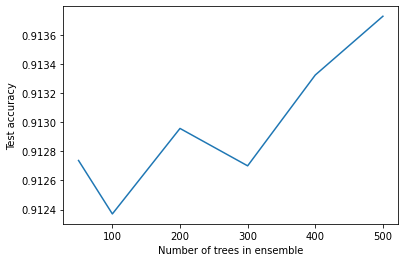

In [37]:
#All of them are overfitting except Gradient Boosting. Both RF and Boosting give similar results for test data
#Best Test F1 Score is for Gradient Boosting

#Let us try to find the best value for no of trees in Gradient Boosting
scores = {}
for num_trees in [50, 100, 200, 300, 400,500]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=2,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')


Text(0, 0.5, 'Test accuracy')

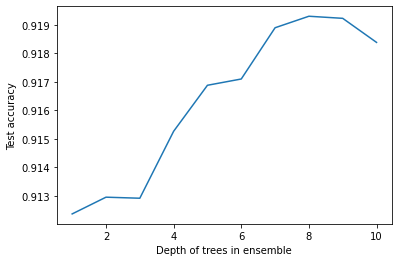

In [38]:
#There is very less difference in these values. So around 200 trees is fine.
#Now checking for depth of trees-
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')


Text(0, 0.5, 'Test accuracy')

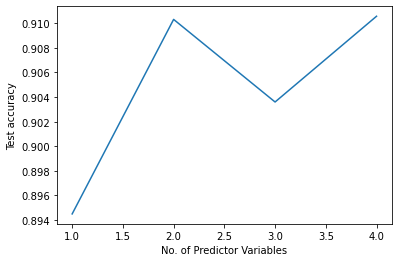

In [39]:
#So, more depth is leading to more accuracy in test set. We can try maxdepth=8
#and no. of trees = 100 for Gradient Boosting.

#Similarly, let us try no. of predictors for Random Forest
scores = {}
for mtry in range(1, 5):
    rf_mtry_model = RandomForestClassifier(n_estimators=mtry,random_state=1)
    rf_mtry_model.fit(X_train, y_train)
    prediction_test = rf_mtry_model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[mtry] = accuracy_test
Series(scores).sort_index().plot()
xlabel('No. of Predictor Variables')
ylabel('Test accuracy')

In [40]:
#So, for Random Forest, we could try mtry=4
# Setting up all the ensemble models now
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=2,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=8,
                               random_state=1)

In [41]:
#Now fitting all these models into training data
#Fitting all the models to our training data
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)


Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


In [42]:
#Accuracy Scores
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
f1_train = {}
f1_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    f1_train[name] = f1_score(y_train, prediction_train, average=None)
    f1_test[name] = f1_score(y_test, prediction_test, average=None)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test, 'Train F1 Score':f1_train, 'Test F1 Score':f1_test})
df


,Training Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
Decision Tree,1.000000,0.892775,"[1.0, 1.0]","[0.9404960697267136, 0.4584877687175686]"
Bagging,0.991256,0.912003,"[0.9951765420317517, 0.9532773109243697]","[0.9522900003979149, 0.43443396226415093]"
Random Forest,0.962601,0.910315,"[0.9796320405646156, 0.7717412171242082]","[0.951586704171784, 0.3920398009950249]"
Gradient Boosting,0.951026,0.919306,"[0.9735388589588893, 0.671795952782462]","[0.95659896974362, 0.42659713168187746]"


In [43]:
#So, using Gradient Boosting we get Test Accuracy of 0.919306 which is better
#than baseline accuracy 0.90

prediction_test_best_model_GB=model.predict(X_test)
accuracy_test_best_model = metrics.accuracy_score(y_test, prediction_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,prediction_test)

array([[24234,   365],
       [ 1834,   818]], dtype=int64)

In [44]:
from sklearn.metrics import precision_score,recall_score
print("Precision is",precision_score(y_test, prediction_test))
print("Recall is",recall_score(y_test, prediction_test))

Precision is 0.6914623837700761
Recall is 0.30844645550527905


In [45]:
# y_train is 0 or 1.
print('Number of positive examples =', len(y_train[y_train==1]))
print('Number of negative examples =', len(y_train[y_train==0]))

negative_examples_in_test = len(y_test[y_test==0])
total_examples_in_test = len(y_test)

print('Number of examples where baseline is correct =', negative_examples_in_test)
print('Baseline accuracy =', negative_examples_in_test * 1.0 / total_examples_in_test)

#Computing Baseline F1 score.
preds = [0] * len(X_test)
print('Baseline F1 score is:',f1_score(y_test,preds))

Number of positive examples = 6188
Number of negative examples = 57397
Number of examples where baseline is correct = 24599
Baseline accuracy = 0.9026824703680599
Baseline F1 score is: 0.0


In [ ]:
#So, baseline accuracy is 0.90268
#Accuracy from Gradient Boosting is 0.919306